/opt/anaconda3/envs/CIS4930ML/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /Users/jadevega/CIS4930-ML-Final-Project
Path to dataset files: /Users/jadevega/.cache/kagglehub/datasets/joebeachcapital/30000-spotify-songs/versions/2
Number of null values in each column track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64
Number of duplicated values in each column:  0


,track_artist,track_name,track_album_name
0,Ed Sheeran,I Don't Care (with Justin Bieber) - Loud Luxur...,I Don't Care (with Justin Bieber) [Loud Luxury...
1,Maroon 5,Memories - Dillon Francis Remix,Memories (Dillon Francis Remix)
2,Zara Larsson,All the Time - Don Diablo Remix,All the Time (Don Diablo Remix)
3,The Chainsmokers,Call You Mine - Keanu Silva Remix,Call You Mine - The Remixes
4,Lewis Capaldi,Someone You Loved - Future Humans Remix,Someone You Loved (Future Humans Remix)
...,...,...,...
32828,Lush & Simon,City Of Lights - Official Radio Edit,City Of Lights (Vocal Mix)
32829,Tegan and Sara,Closer - Sultan & Ned Shepard Remix,Closer Remixed
32830,Starkillers,Sweet Surrender - Radio Edit,Sweet Surrender (Radio Edit)
32831,Mat Zo,Only For You - Maor Levi Remix,Only For You (Remixes)


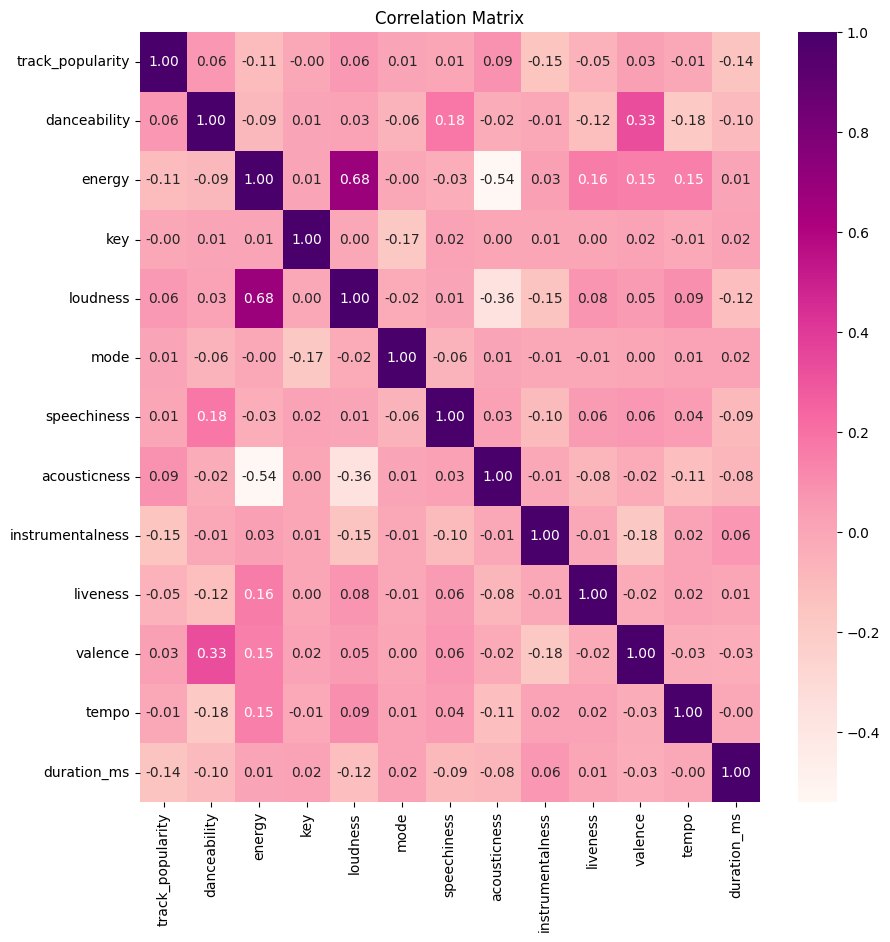

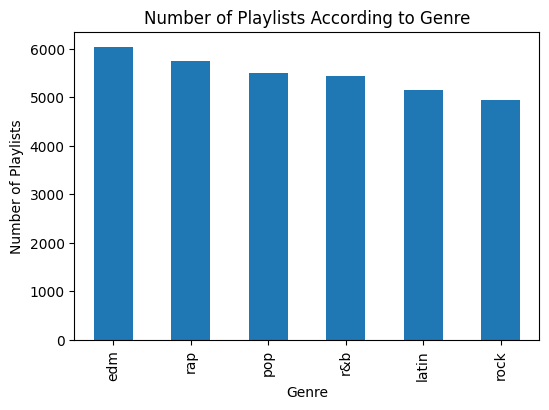

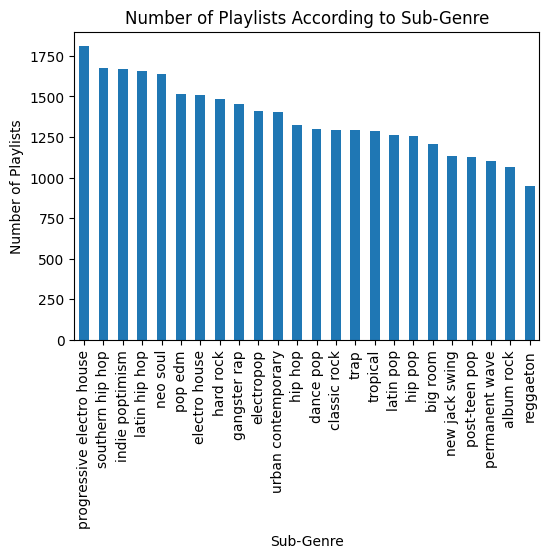

Number of Rows and Columns in Dataset without Metadata (32828, 16)
Number of Rows and Columns in Dataset with Metadata (32828, 3)


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000
mean,42.483551,0.654850,0.698603,5.373949,-6.719529,0.565737,0.107053,0.175352,0.084760,0.190175,0.510556,120.883642,225796.829779
std,24.980476,0.145092,0.180916,3.611572,2.988641,0.495667,0.101307,0.219644,0.224245,0.154313,0.233152,26.903632,59836.492346
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171250,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.961000,187804.500000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918250,253581.250000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


,track_artist,track_name,track_album_name
0,Ed Sheeran,I Don't Care (with Justin Bieber) - Loud Luxur...,I Don't Care (with Justin Bieber) [Loud Luxury...
1,Maroon 5,Memories - Dillon Francis Remix,Memories (Dillon Francis Remix)
2,Zara Larsson,All the Time - Don Diablo Remix,All the Time (Don Diablo Remix)
3,The Chainsmokers,Call You Mine - Keanu Silva Remix,Call You Mine - The Remixes
4,Lewis Capaldi,Someone You Loved - Future Humans Remix,Someone You Loved (Future Humans Remix)


In [1]:
#load dataset, fix null/duplicated values and remove useless cat cols and save important cat cols. 

# !pip install seaborn kagglehub scikit-learn
!pip install imbalanced-learn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
import os
print("Current working directory:", os.getcwd())
# Download latest version
path = kagglehub.dataset_download("joebeachcapital/30000-spotify-songs")
print("Path to dataset files:", path)

csv_path = os.path.join(path, "spotify_songs.csv")
spotify_df_full = pd.read_csv(csv_path)

## spotify_df_full = pd.read_csv('data/spotify_songs.csv')


#check num of null values in each feature
print("Number of null values in each column", spotify_df_full.isnull().sum())

#check num of duplicated values in each feature
print("Number of duplicated values in each column: ", spotify_df_full.duplicated().sum())

#drop duplicates & drop null values
spotify_df = spotify_df_full.drop_duplicates().dropna()


#drop categorical values that aren't going to be used
spotify_df = spotify_df.drop(columns=["track_id" , "track_album_id", "track_album_release_date", "playlist_id"])


#save important categorical information in a different df
recommendation_info = spotify_df[['track_artist', 'track_name', 'track_album_name']]
display(recommendation_info)


#see if any values are highly correlated > 0.75 because to prevent inflation of feature importance. 
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = spotify_df[numerical_cols].corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap="RdPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


plt.figure(figsize=(6,4))
playlist_genre = spotify_df['playlist_genre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Genre")
plt.title("Number of Playlists According to Genre")
plt.show()

plt.figure(figsize=(6,4))
subgr = spotify_df['playlist_subgenre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Sub-Genre")
plt.title("Number of Playlists According to Sub-Genre")
plt.show()
spotify_df = spotify_df.drop(columns=['track_artist', 'track_name', 'track_album_name'])

print(f'Number of Rows and Columns in Dataset without Metadata {spotify_df.shape}')
print(f'Number of Rows and Columns in Dataset with Metadata {recommendation_info.shape}')

display(spotify_df.describe())
display(recommendation_info.head())

In [2]:
#features with many outliers: sppechniqess, acousticness, instrumentallness
#features with some outliers: loudness, liveness, duration_ms
#loudness is negative values. 

#fixing outliers

#select numerical cols from the dataset. 
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns



#empty dict to keep track of how many outliers per col. 
out_sum = {}

for col in numerical_cols:
    Q1 = spotify_df[col].quantile(0.25)
    Q3 = spotify_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    #check num lower/upper outliers and add to dict. 
    outlier = ((spotify_df[col] < lower_bound) | (spotify_df[col] > upper_bound)).sum()
    out_sum[col] = outlier

display(out_sum)


{'track_popularity': np.int64(0),
 'danceability': np.int64(291),
 'energy': np.int64(277),
 'key': np.int64(0),
 'loudness': np.int64(1021),
 'mode': np.int64(0),
 'speechiness': np.int64(3174),
 'acousticness': np.int64(2205),
 'instrumentalness': np.int64(7030),
 'liveness': np.int64(1842),
 'valence': np.int64(0),
 'tempo': np.int64(571),
 'duration_ms': np.int64(1387)}

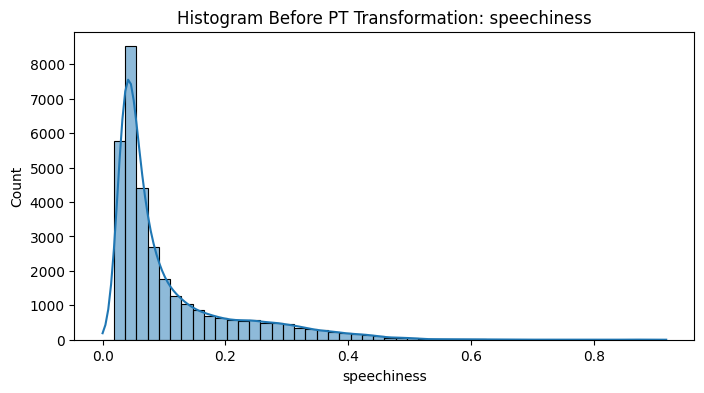

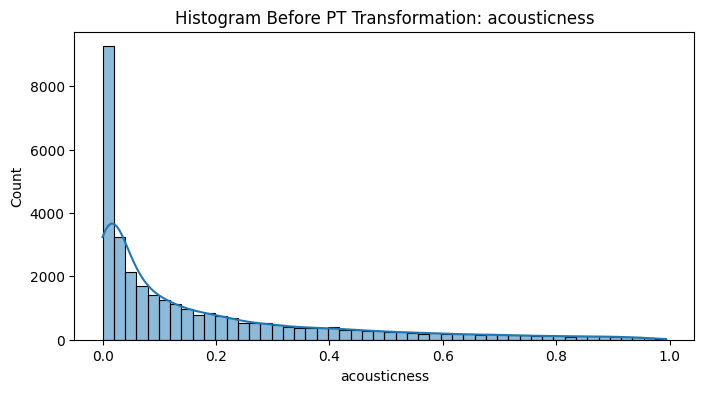

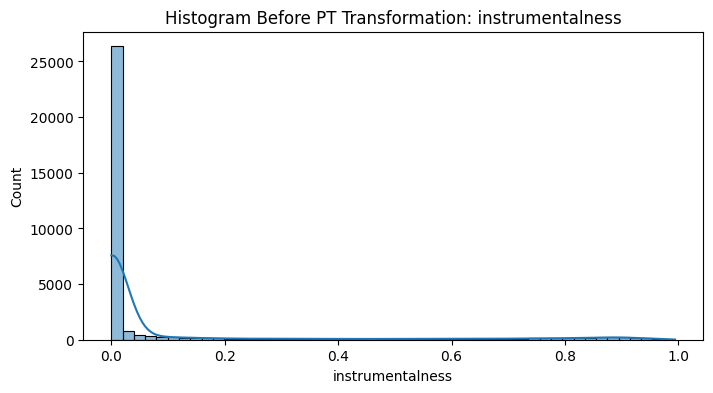

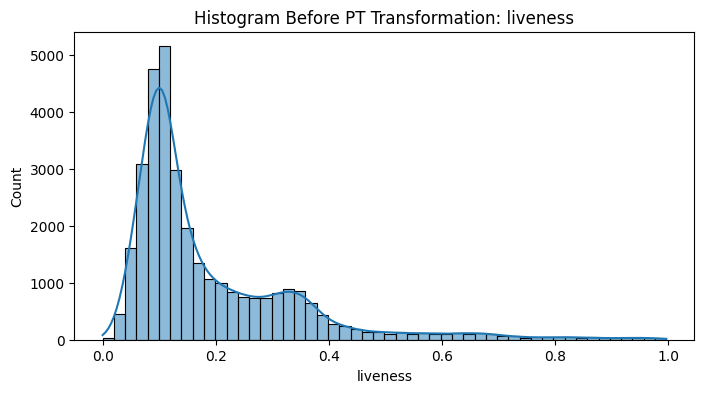

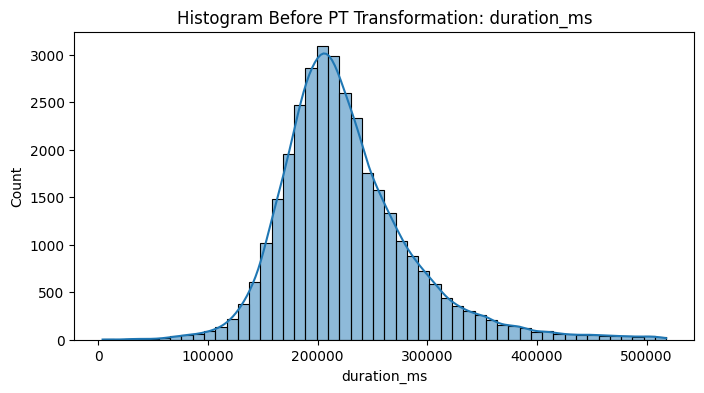

In [3]:
most_outliers = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']


for col in most_outliers:
    plt.figure(figsize=(8,4))
    sns.histplot(spotify_df[col], kde=True, bins=50)
    plt.title(f"Histogram Before PT Transformation: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

    

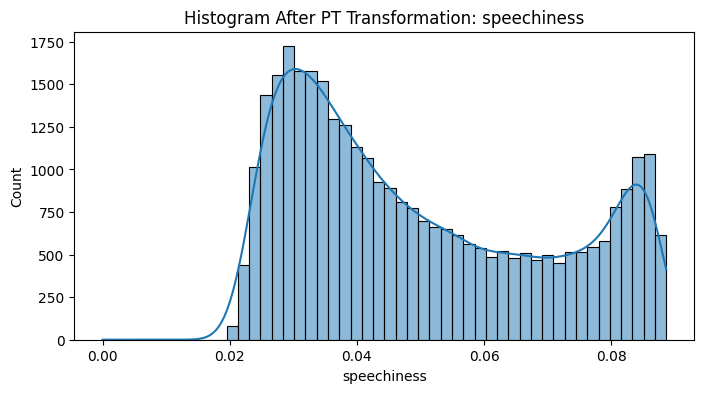

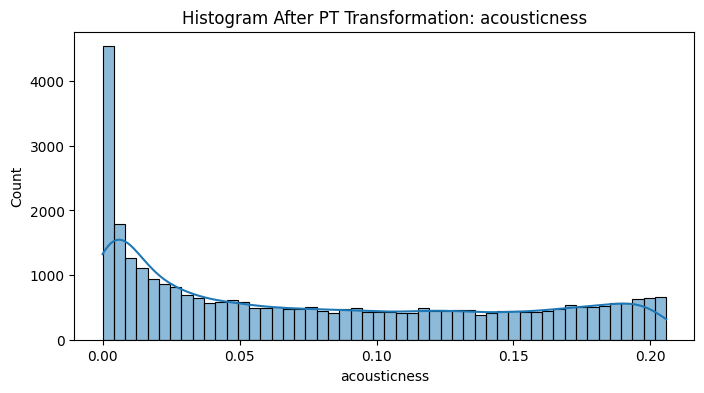

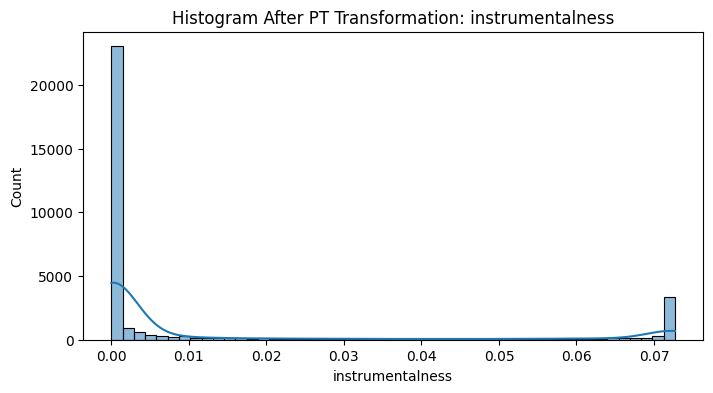

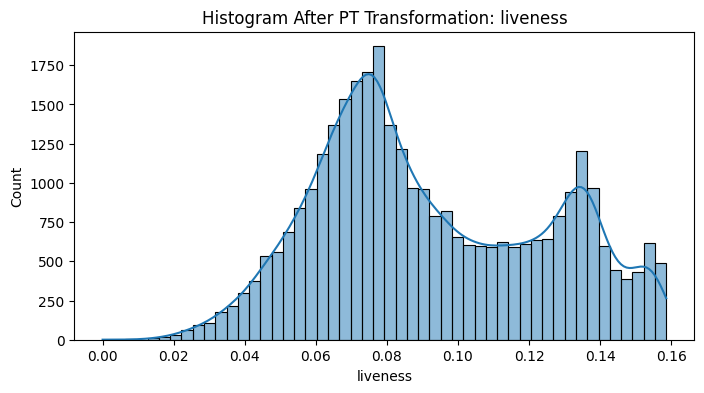

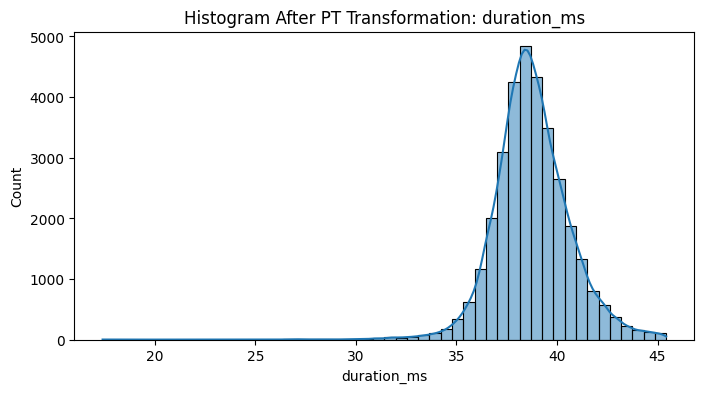

In [4]:
#transform skewed values reduce influence of extremely large values
from sklearn.preprocessing import PowerTransformer


import numpy as np
skewed = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']
pt = PowerTransformer(method='yeo-johnson', standardize=False)
spotify_df[skewed] = pt.fit_transform(spotify_df[skewed])

for col in skewed: 
    plt.figure(figsize=(8,4))
    sns.histplot(spotify_df[col], kde=True, bins=50)
    plt.title(f"Histogram After PT Transformation: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



In [5]:
#frequency encoding for name and playlist subgenre; good for features with high cardinality. 

freq_cols = ['playlist_name', 'playlist_subgenre']

for col in freq_cols:
    freq = spotify_df[col].value_counts(normalize=True)
    spotify_df[col] = spotify_df[col].map(freq)

In [6]:
from sklearn.preprocessing import OneHotEncoder
#can be used for genre because there's only 6 diff genres. 
labelgenre_encoder = OneHotEncoder(sparse_output = False)

genre = labelgenre_encoder.fit_transform(spotify_df[['playlist_genre']])

genre_df = pd.DataFrame(genre, columns = labelgenre_encoder.get_feature_names_out(['playlist_genre']), index=spotify_df.index)
spotify_df= spotify_df.drop(columns=['playlist_genre'])
spotify_df = pd.concat([spotify_df, genre_df], axis=1)

display(spotify_df)
print(spotify_df.shape)

,track_popularity,playlist_name,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock
0,66,0.002132,0.039539,0.748,0.916,6,-2.634,1,0.041874,0.078098,...,0.052297,0.5180,122.036,37.911945,0.0,0.0,1.0,0.0,0.0,0.0
1,67,0.002132,0.039539,0.726,0.815,11,-4.969,1,0.030002,0.059645,...,0.136710,0.6930,99.972,36.648808,0.0,0.0,1.0,0.0,0.0,0.0
2,70,0.002132,0.039539,0.675,0.931,1,-3.432,0,0.049120,0.064270,...,0.076771,0.6130,124.008,37.223062,0.0,0.0,1.0,0.0,0.0,0.0
3,60,0.002132,0.039539,0.718,0.930,7,-3.778,1,0.059025,0.026508,...,0.110113,0.2770,121.956,36.919796,0.0,0.0,1.0,0.0,0.0,0.0
4,69,0.002132,0.039539,0.650,0.833,1,-4.672,1,0.029102,0.064852,...,0.063034,0.7250,123.976,37.701403,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,42,0.002437,0.055105,0.428,0.922,2,-1.814,1,0.056352,0.062440,...,0.053242,0.2100,128.170,38.255747,1.0,0.0,0.0,0.0,0.0,0.0
32829,20,0.002437,0.055105,0.522,0.786,0,-4.462,1,0.032919,0.001702,...,0.138605,0.4000,128.041,42.347357,1.0,0.0,0.0,0.0,0.0,0.0
32830,14,0.002437,0.055105,0.529,0.821,6,-4.899,0,0.036472,0.081506,...,0.093375,0.4360,127.989,38.454343,1.0,0.0,0.0,0.0,0.0,0.0
32831,15,0.002437,0.055105,0.626,0.888,2,-3.361,1,0.061070,0.007745,...,0.135105,0.3080,128.008,42.658894,1.0,0.0,0.0,0.0,0.0,0.0


(32828, 21)


In [7]:
#scale numerical values
from sklearn.preprocessing import StandardScaler
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
spotify_df[numerical_cols] = scaler.fit_transform(spotify_df[numerical_cols])


In [8]:
val_30 = spotify_df['valence'].quantile(0.30)
val_70 = spotify_df['valence'].quantile(0.70)

energy_30 = spotify_df['energy'].quantile(0.30)
energy_70 = spotify_df['energy'].quantile(0.70)

tempo_30 = spotify_df['tempo'].quantile(0.30)
tempo_70 = spotify_df['tempo'].quantile(0.70)

def mood_logic(row):
    val = row['valence']
    energy = row['energy']
    temp = row['tempo']

    if (energy >= energy_70) and (temp >= tempo_70):
        return "hype"

    elif (val >= val_70) and (energy >= energy_30):
        return "happy"

    elif ((val <= val_30) and (energy <= energy_30)) and (temp <= tempo_30):
        return "sad"

    elif (temp <= tempo_30) and (energy <= energy_70):
        return "chill"

    return "vibey"

In [9]:
spotify_df["mood"] = spotify_df.apply(mood_logic, axis=1)
spotify_df["mood"].value_counts()

recommendation_info = recommendation_info.reset_index(drop=True)
spotify_df = spotify_df.reset_index(drop=True)

full_df = pd.concat([recommendation_info, spotify_df], axis=1)

['chill' 'happy' 'hype' 'sad' 'vibey']


/opt/anaconda3/envs/CIS4930ML/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Linear Log Regression:                precision    recall  f1-score   support

           0       0.82      0.85      0.84      3309
           1       0.82      0.83      0.82      3308
           2       0.81      0.85      0.83      3308
           3       0.89      0.93      0.91      3309
           4       0.86      0.75      0.80      3308

    accuracy                           0.84     16542
   macro avg       0.84      0.84      0.84     16542
weighted avg       0.84      0.84      0.84     16542



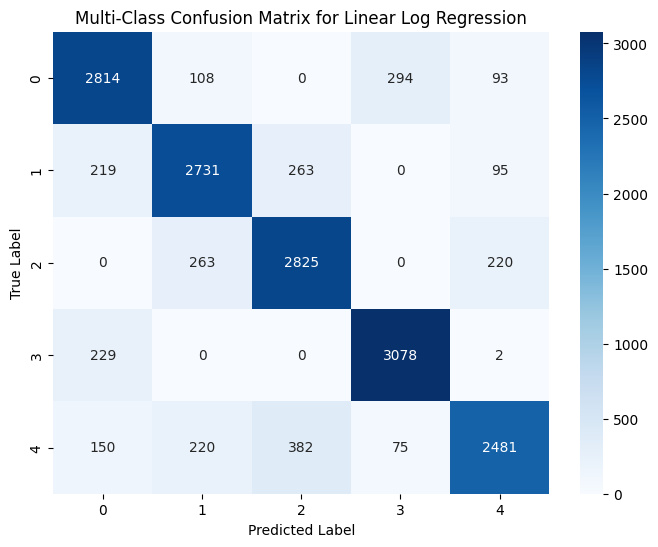

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

features = [
    'valence', 'energy', 'danceability', 'tempo',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'duration_ms'
]

X = spotify_df[features]
y = spotify_df['mood']


le = LabelEncoder()
spotify_df['mood_encoded'] = le.fit_transform(spotify_df['mood'])

y = spotify_df['mood_encoded']

print(le.classes_)
spotify_df[['mood', 'mood_encoded']].head(10)


sm = SMOTE(random_state=42) 
X_resampled, y_resampled = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


logreg = LogisticRegression(
    max_iter=600,
    multi_class='multinomial',
    solver='lbfgs'
)

logreg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = logreg.predict(X_test)

print("Classification Report for Linear Log Regression: ", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.title('Multi-Class Confusion Matrix for Linear Log Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



/opt/anaconda3/envs/CIS4930ML/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for Poly Log Regression:                precision    recall  f1-score   support

           0       0.98      0.98      0.98      3309
           1       0.98      0.98      0.98      3308
           2       0.99      0.99      0.99      3308
           3       0.99      1.00      0.99      3309
           4       0.98      0.96      0.97      3308

    accuracy                           0.98     16542
   macro avg       0.98      0.98      0.98     16542
weighted avg       0.98      0.98      0.98     16542



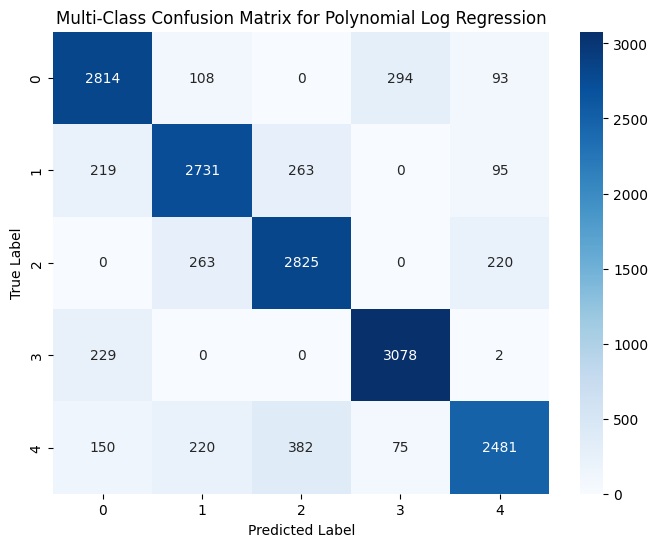

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)

X_poly = poly.fit_transform(X)

sm = SMOTE(random_state=42) 
X_poly_resampled, y_poly_resampled = sm.fit_resample(X_poly, y)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly_resampled, y_poly_resampled, test_size=0.2, random_state=42, stratify=y_poly_resampled)

logregpoly = LogisticRegression(
    max_iter=600,
    multi_class='multinomial',
    solver='lbfgs'
)
logregpoly.fit(X_poly_train, y_poly_train)
y_poly_pred = logregpoly.predict(X_poly_test)


print("Classification Report for Poly Log Regression: ", classification_report(y_poly_test, y_poly_pred))

cmpoly = confusion_matrix(y_poly_test, y_poly_pred)
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.title('Multi-Class Confusion Matrix for Polynomial Log Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
full_df.to_csv("data/full_df_cleaned.csv", index=False)
print("Saved cleaned dataset to full_df_cleaned.csv")